In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from src.scripts.save_plotly import save_plotly
from src.scripts import timeseries_anim

from src.scripts.clinical_trials import (
    combine_trials_json,
    plot_clinical_counts,
    classify_disease,
    load_clinical_trials_data,
)

from src.scripts.pc import (
    merge_citations_with_targets,
    process_and_merge_patents,
    clean_and_transform_IC50,
    kmeans_selection,
)

In [2]:
df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
        "Patent Number",
        "ZINC ID of Ligand",
    ],
)

/var/folders/v6/k76v8jrj1tj5gl6k8swh19x40000gp/T/ipykernel_40080/2446788585.py:1: DtypeWarning: Columns (9,17,21,23,33,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
# load initial data
uniprot_ids = [
    "P07949",
    "P14416",
]
targets = timeseries_anim.filter_RET(df, uniprot_ids=uniprot_ids)

In [4]:
uniprot_ids_names_mapping = {"P07949": "RET", "P14416": "D(2) dopamine receptor"}

In [5]:
targets = targets.drop_duplicates(subset=["Ligand SMILES"])

In [6]:
targets

,Ligand SMILES,IC50 (nM),Article DOI,Patent Number,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain
38708,CSc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586566,P14416
38709,COc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586534,P14416
38710,Cc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586576,P14416
38711,CC(=O)c1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586546,P14416
38712,Oc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586570,P14416
...,...,...,...,...,...,...,...,...
2918652,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,NaN,NaN,P07949
2918653,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,NaN,NaN,P07949
2919067,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,P14416
2920980,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,NaN,NaN,P07949


In [7]:
targets = merge_citations_with_targets(targets)

In [8]:
targets

,Ligand SMILES,IC50 (nM),Patent Number,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation
1,Nc1ccccc1C(=O)NCCCCN1CCN(CC1)c1nsc2ccccc12,NaN,NaN,University of Toronto,NaN,ZINC01537573,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
2,NCCc1c[nH]c2ccc(O)cc12,NaN,NaN,University of Toronto,NaN,ZINC00057058,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
3,[NH3+][C@@H]1CCc2cc(O)c(O)cc2C1,NaN,NaN,University of Toronto,NaN,ZINC03872369,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
4,NCC(O)c1ccc(O)c(O)c1,NaN,NaN,University of Toronto,NaN,ZINC00057624,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
5,CN1C[C@H](CSc2ccccn2)C[C@@H]2Cc3c(O)cccc3C[C@@...,NaN,NaN,University of Toronto,NaN,ZINC03826945,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
...,...,...,...,...,...,...,...,...,...
54809,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,NaN,P07949,NaN,NaN
54810,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,NaN,P07949,NaN,NaN
54811,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,P14416,NaN,NaN
54812,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,NaN,P07949,NaN,NaN


In [9]:
targets = process_and_merge_patents(targets)

In [10]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations
54,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)OC(C...,35.8,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
55,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCNCC2)c2c(cnn2c1...,19.6,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
56,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)CCS(...,11.9,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
57,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)[C@@...,3.10,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
58,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)Cc2c...,4.60,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
...,...,...,...,...,...,...,...,...,...,...,...
22151,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22152,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22153,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN
22154,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN


In [11]:
paths = [
    "../src/data/ZINC_references_trials_amel.json",
    "../src/data/ZINC_references_trials_daphne.json",
    "../src/data/ZINC_references_trials_wes.json",
    "../src/data/ZINC_references_trials_greg.json",
    "../src/data/ZINC_references_trials_guillaume.json",
]
df_all = combine_trials_json(paths)
df_all

,ZINC ID of Ligand,code,description,status_name,phase_name,start_date
0,ZINC03814434,NCT03114228,An Expanded Treatment Protocol (ETP) of Midost...,No longer available,None,None
1,ZINC03814434,NCT02624570,Midostaurin Access Program for Newly Diagnosed...,Available,None,None
2,ZINC03814434,NCT03258931,Study of Crenolanib vs Midostaurin Following I...,Not yet recruiting,Phase 3,2018-05-01
3,ZINC03814434,NCT03207334,iCare4: Genomic Signatures With Midostaurin in...,Not yet recruiting,Phase 2,2018-05-01
4,ZINC03814434,NCT03092674,Azacitidine With or Without Nivolumab or Midos...,Recruiting,Phase 2/Phase 3,2017-12-22
...,...,...,...,...,...,...
340574,ZINC00056568,NCT00004871,Azacitidine Plus Phenylbutyrate in Treating Pa...,Completed,Phase 1,2000-05-01
340575,ZINC00056568,NCT00002796,Phase I-II Study of Fluorouracil in Combinatio...,Terminated,Phase 1/Phase 2,1997-05-01
340576,ZINC00056568,NCT00002909,Phenylbutyrate in Treating Patients With Refra...,Completed,Phase 1,1997-02-01
340577,ZINC00056568,NCT00001565,Phase I and Pharmacokinetic Trial of Phenylbut...,Completed,Phase 1,1996-12-01


In [12]:
phase_4_count_df = (
    df_all.query("status_name == 'Completed'")
    .value_counts(["ZINC ID of Ligand", "phase_name"])
    .reset_index()
    .query("phase_name == 'Phase 4'")
    .rename(columns={"count": "phase_4_count"})
    .drop(columns="phase_name")
)

In [13]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations
54,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)OC(C...,35.8,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
55,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCNCC2)c2c(cnn2c1...,19.6,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
56,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)CCS(...,11.9,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
57,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)[C@@...,3.10,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
58,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)Cc2c...,4.60,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
...,...,...,...,...,...,...,...,...,...,...,...
22151,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22152,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22153,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN
22154,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN


In [14]:
targets = pd.merge(
    left=targets,
    right=phase_4_count_df,
    left_on="ZINC ID of Ligand",
    right_on="ZINC ID of Ligand",
    how="outer",
).dropna(subset="Ligand SMILES")

In [15]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count
2,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN
4,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0
10,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN
11,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN
14,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15436,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN
15437,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN
15438,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN
15439,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
targets = clean_and_transform_IC50(targets, IC50_column="IC50 (nM)")

In [17]:
# fingerprints
targets = timeseries_anim.get_ligands_fingerprint(targets)

[14:57:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:57:25] Explicit valence for atom # 35 N, 4, is greater than permitted
[14:57:25] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:57:25] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:57:26] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[14:57:26] Explicit valence for atom # 32 O, 3, is greater than permitted
[14:57:26] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[14:57:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:57:27] Can't 

In [18]:
# pca applied to each target seperately
store = []
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    temp = targets[
        targets["UniProt (SwissProt) Primary ID of Target Chain"] == target
    ].copy()
    temp, _, _ = timeseries_anim.PCA_fingerprints(temp)
    store.append(temp)
result = pd.concat(store, ignore_index=True)

## final data has info for pca overlayed with:
# - ic50
# - citations (article)
# - patent citations
result

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388699,0.626371,-0.917787
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859429,-0.476653,-0.969750
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861943,-0.468635,-0.925652
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.160107,0.396562,-1.348675
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.151797,-2.323273,-1.663174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14912,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.103183,-4.110087,7.082610
14913,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.221582,-6.250520,9.500938
14914,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.787971,-6.472867,12.563299
14915,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.123076,-1.857014,1.537266


In [19]:
result = result.drop_duplicates(subset=["Ligand SMILES"])

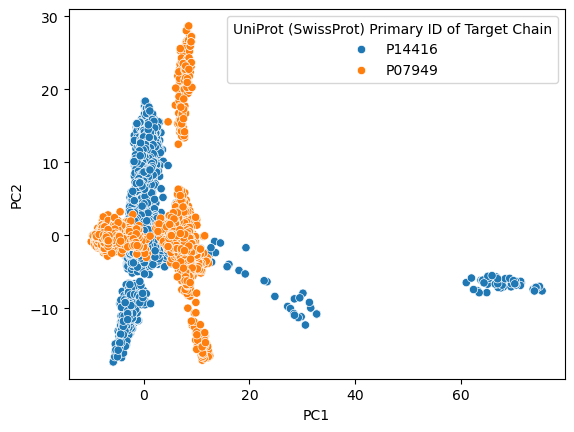

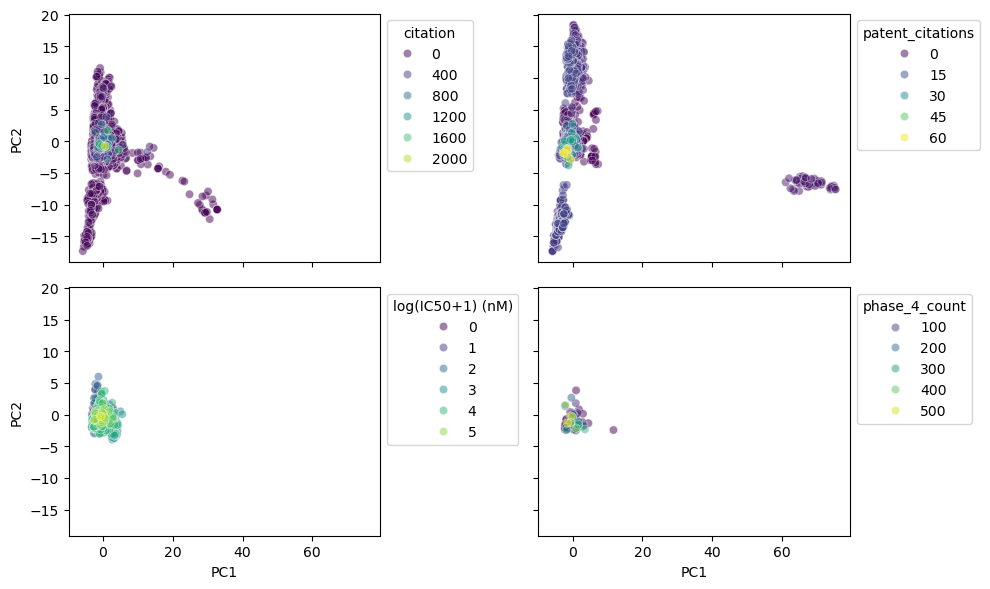

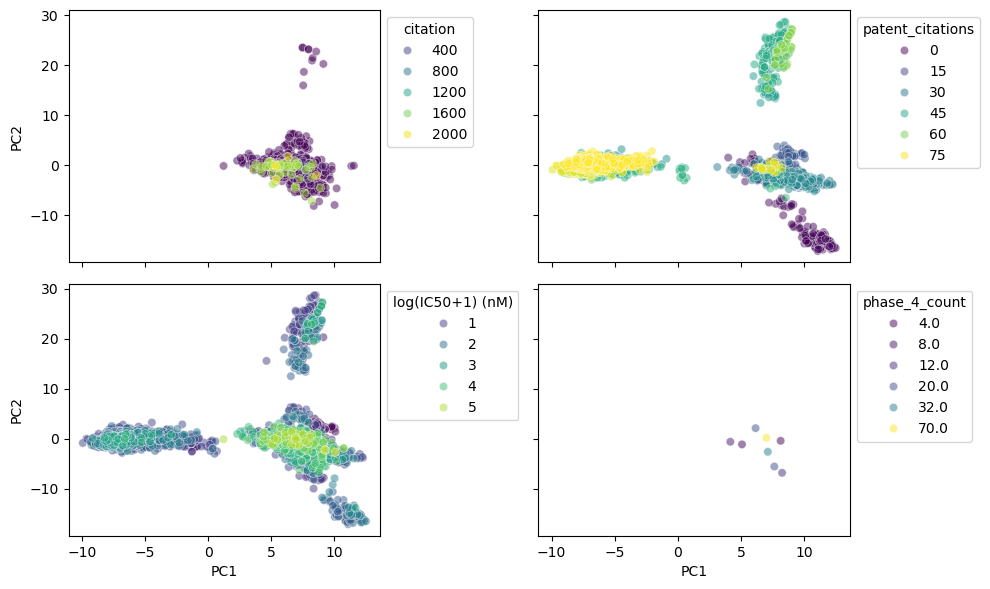

In [ ]:
# pcas of each target
sns.scatterplot(
    result, x="PC1", y="PC2", hue="UniProt (SwissProt) Primary ID of Target Chain"
)

plt.show()

# seperating each pca and overlaying stuff
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 6))
    for ax, hue in zip(
        axs.flatten(),
        ["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"],
    ):
        sns.scatterplot(
            result[
                result["UniProt (SwissProt) Primary ID of Target Chain"] == target
            ].sort_values(hue),
            x="PC1",
            y="PC2",
            hue=hue,
            ax=ax,
            palette="viridis",
            alpha=0.5,
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [21]:
uniprot_ids_names_mapping

{'P07949': 'RET', 'P14416': 'D(2) dopamine receptor'}

In [22]:
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target]

    # Compute the global x and y ranges based on the full dataset
    x_range = [1.1 * result_["PC1"].min(), 1.1 * result_["PC1"].max()]
    y_range = [1.1 * result_["PC2"].min(), 1.1 * result_["PC2"].max()]

    fig = go.Figure()

    # List of hue variables
    hue_variables = [
        "citation",
        "patent_citations",
        "log(IC50+1) (nM)",
        "phase_4_count",
    ]
    title = f"{uniprot_ids_names_mapping[target]} Ligand Fingerprint PC1 vs PC2"

    # Loop through each hue variable, filter out NaN values, and add as a separate trace
    for hue in hue_variables:
        filtered_data = result_.dropna(subset=[hue]).sort_values(hue)

        fig.add_trace(
            go.Scatter(
                x=filtered_data["PC1"],
                y=filtered_data["PC2"],
                mode="markers",
                marker=dict(
                    size=8,
                    color=filtered_data[hue],
                    colorscale="Viridis",
                    showscale=True,
                    colorbar=dict(
                        title=hue.capitalize().replace("_", " ")
                    ),  # Custom colorbar title
                ),
                name=hue,  # Name will be used in the dropdown menu
                visible=False,  # Initially hidden; we will toggle visibility
            )
        )

    fig.data[0].visible = True

    # dropdown menu
    dropdown_buttons = [
        dict(
            label=hue.capitalize().replace("_", " "),
            method="update",
            args=[
                {"visible": [i == idx for i in range(len(hue_variables))]},
                {
                    "title": f"{title} with {hue.capitalize().replace('_', ' ')} overlayed"
                },  # dynamic title
            ],
        )
        for idx, hue in enumerate(hue_variables)
    ]

    # dropdown menu layout
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
            )
        ],
        title={
            "text": title,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis=dict(title="PC1", range=x_range),
        yaxis=dict(title="PC2", range=y_range),
        template="plotly_dark",
    )

    fig.show()

In [23]:
result

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388699,0.626371,-0.917787
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859429,-0.476653,-0.969750
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861943,-0.468635,-0.925652
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.160107,0.396562,-1.348675
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.151797,-2.323273,-1.663174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14912,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.103183,-4.110087,7.082610
14913,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.221582,-6.250520,9.500938
14914,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.787971,-6.472867,12.563299
14915,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.123076,-1.857014,1.537266


In [24]:
result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P14416"]

In [25]:
result_

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388699,0.626371,-0.917787
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859429,-0.476653,-0.969750
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861943,-0.468635,-0.925652
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.160107,0.396562,-1.348675
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.151797,-2.323273,-1.663174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,CCCN(CCc1cc(O)c(CCN(CCC)[C@H]2CCc3nc(N)sc3C2)c...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.084804,0.672627,0.992941
10408,CCCN(CCc1ccc(CCN(CCC)[C@H]2CCc3c(O)cccc3C2)cc1...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.082016,-2.392834,-1.189518
10409,Fc1ccc(CN2CCCC22CCN(Cc3cc4ccc(Cl)cc4[nH]3)C2)cc1F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.135123,-2.973189,-0.034892
10410,Fc1ccc(CN2CCCC3(CCN(Cc4cc5ccc(Cl)cc5[nH]4)C3)C...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.157632,-2.118289,-0.073984


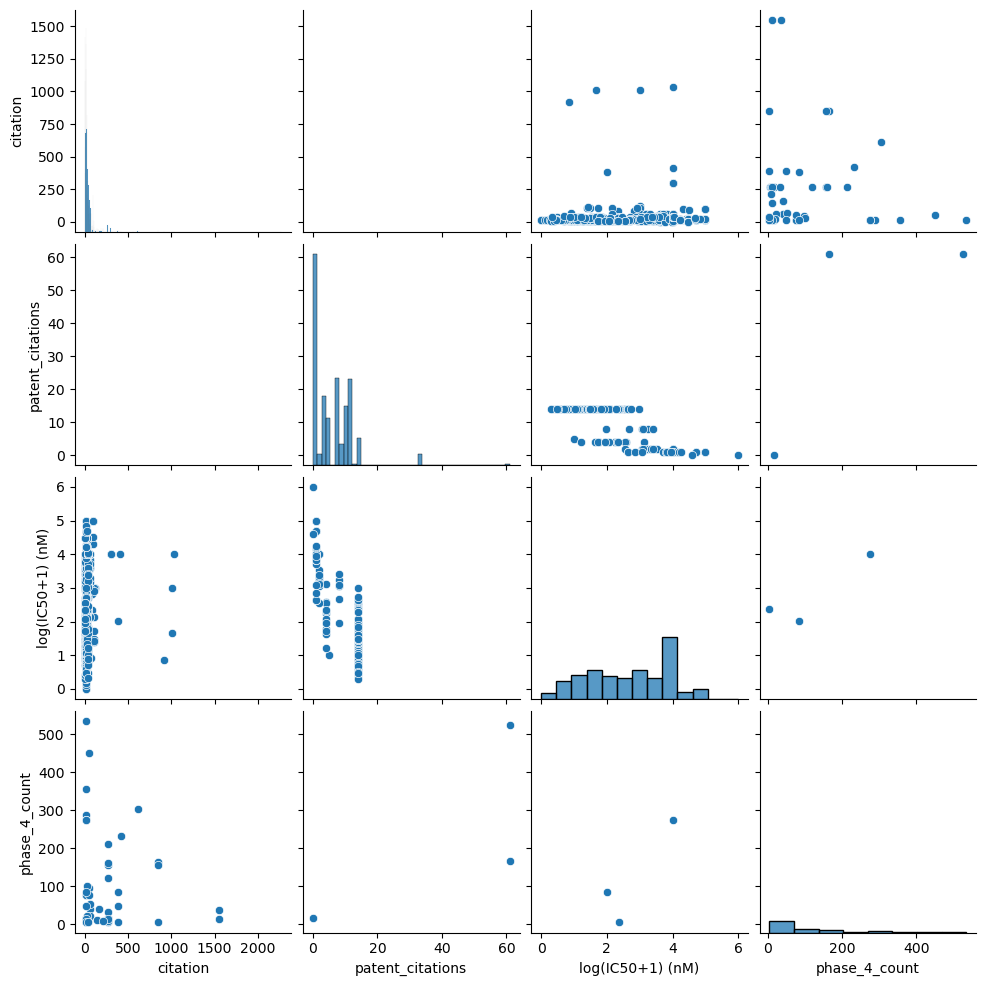

In [26]:
sns.pairplot(
    result_[["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"]]
)

# Clustering

In [ ]:
result = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"]
kmeans_selection_df = pd.DataFrame(
    kmeans_selection(result[["PC1", "PC2", "PC3"]], range(2, 10))
)
kmeans_selection_df

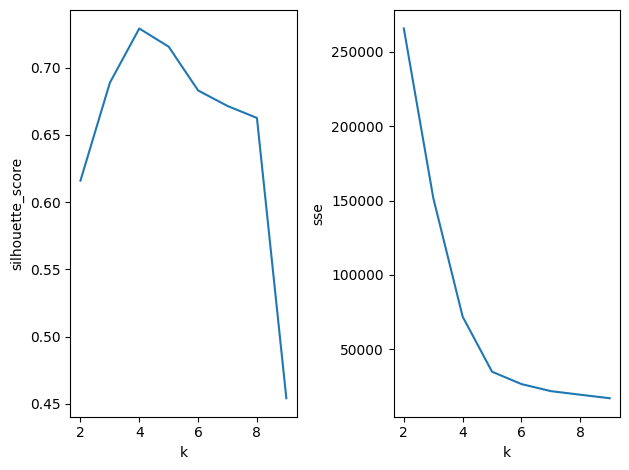

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.lineplot(kmeans_selection_df, x="k", y="silhouette_score", ax=ax1)
sns.lineplot(kmeans_selection_df, x="k", y="sse", ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=10).fit(result[["PC1", "PC2", "PC3"]])
result["cluster"] = kmeans.predict(result[["PC1", "PC2", "PC3"]])
result

/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_55626/3381879016.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3,cluster
10410,COc1cc2ncnc(Nc3cc(O)c(C)cc3F)c2cc1OC,0.75,University of Manchester,NaN,ZINC00006952,P07949,10.1016/j.ejmech.2016.01.039,33.0,NaN,NaN,NaN,NaN,0.243038,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.991971,-1.673965,3.074150,1
10411,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,NaN,Ambit Biosciences,DB04879,ZINC00007460,P07949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.386514,-1.105859,-0.144132,1
10412,COc1cc2ncnc(Nc3ccc(O)cc3)c2cc1OC,720.00,University of Manchester,NaN,ZINC00009851,P07949,10.1016/j.ejmech.2016.01.039,33.0,NaN,NaN,NaN,NaN,2.857935,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.263690,-3.362430,2.210753,1
10413,O=C1Nc2ccccc2\C1=C\c1ccc(s1)-c1cccs1,9400.00,"Universit&#163; di Napoli ""Federico II""",NaN,ZINC00110550,P07949,10.1016/j.ejmech.2018.02.080,14.0,NaN,NaN,NaN,NaN,3.973174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6.498130,-0.214195,-1.261968,1
10414,COc1cc2ncnc(Nc3ccccc3)c2cc1OC,1700.00,University of Manchester,NaN,ZINC00116934,P07949,10.1016/j.bmcl.2016.03.100,8.0,NaN,NaN,NaN,NaN,3.230704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.689800,-2.813939,2.440220,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14803,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.035355,-4.095936,7.109941,1
14804,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.159491,-6.241867,9.485063,1
14805,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.713965,-6.485032,12.574770,3
14806,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.176428,-1.869996,1.558435,1


In [ ]:
fig = px.scatter_3d(
    result,
    x="PC1",
    y="PC2",
    z="PC3",
    # animation_frame="current_year",
    # animation_group="Ligand SMILES",  # Or another unique identifier
    color="cluster",
    # hover_data=[
    #     "Institution",
    #     "Article DOI",
    #     "year",
    #     "IC50 (nM)",
    # ],
    # size="max(log(IC50), 0)",
    # size="|log(IC50) (nM)|",
    # size_max=10,
    # range_x=[
    #     1.1 * target_cumulative_with_IC50["PC1"].min(),
    #     1.1 * target_cumulative_with_IC50["PC1"].max(),
    # ],
    # range_y=[
    #     1.1 * target_cumulative_with_IC50["PC2"].min(),
    #     1.1 * target_cumulative_with_IC50["PC2"].max(),
    # ],
    # range_z=[
    #     1.1 * target_cumulative_with_IC50["PC3"].min(),
    #     1.1 * target_cumulative_with_IC50["PC3"].max(),
    # ],
    # template="plotly_dark",
)
fig.update_traces(marker=dict(size=2))

fig.update_layout(
    title={
        "text": "Principal Component Analysis of SMILES Fingerprint Across Time, overlayed with log(IC50)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    scene=dict(
        aspectmode="cube",
    ),
)

fig.show()

In [ ]:
result

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3,cluster
10410,COc1cc2ncnc(Nc3cc(O)c(C)cc3F)c2cc1OC,0.75,University of Manchester,NaN,ZINC00006952,P07949,10.1016/j.ejmech.2016.01.039,33.0,NaN,NaN,NaN,NaN,0.243038,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.991971,-1.673965,3.074150,1
10411,Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,NaN,Ambit Biosciences,DB04879,ZINC00007460,P07949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.386514,-1.105859,-0.144132,1
10412,COc1cc2ncnc(Nc3ccc(O)cc3)c2cc1OC,720.00,University of Manchester,NaN,ZINC00009851,P07949,10.1016/j.ejmech.2016.01.039,33.0,NaN,NaN,NaN,NaN,2.857935,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.263690,-3.362430,2.210753,1
10413,O=C1Nc2ccccc2\C1=C\c1ccc(s1)-c1cccs1,9400.00,"Universit&#163; di Napoli ""Federico II""",NaN,ZINC00110550,P07949,10.1016/j.ejmech.2018.02.080,14.0,NaN,NaN,NaN,NaN,3.973174,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6.498130,-0.214195,-1.261968,1
10414,COc1cc2ncnc(Nc3ccccc3)c2cc1OC,1700.00,University of Manchester,NaN,ZINC00116934,P07949,10.1016/j.bmcl.2016.03.100,8.0,NaN,NaN,NaN,NaN,3.230704,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.689800,-2.813939,2.440220,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14803,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.035355,-4.095936,7.109941,1
14804,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.159491,-6.241867,9.485063,1
14805,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",8.713965,-6.485032,12.574770,3
14806,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.00,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.176428,-1.869996,1.558435,1


In [ ]:
result.groupby("cluster").aggregate({"log(IC50+1) (nM)": "mean"})

,log(IC50+1) (nM)
cluster,
0,1.509190
1,1.883812
2,1.556228
3,1.718223
